In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.decomposition import IncrementalPCA, MiniBatchNMF
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score, make_scorer

import random
from collections import Counter
import pickle
import joblib
import pydicom
import cv2
import matplotlib.pyplot as plt


import data_splitter as ds
import data_loader as dl
import feature_extraction as fex
import run_model as rm

2023-04-06 00:55:07.982915: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-06 00:55:16.249259: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV

In [2]:
%load_ext autoreload
%autoreload 2

# Hyperparameter search
Using 25 % of the training set and the PCA model trained on fold 0 as feature extractor

In [5]:
def hp_search(pipline, param_grid, random_state, min_resources, verbose=2):
    
    grid = HalvingRandomSearchCV(
    pipeline,
    cv = StratifiedKFold(n_splits=5, random_state=random_state, shuffle=True),
    param_distributions = param_grid,
    
    factor = 5, # 1/5 candidates selected in each iteration
    aggressive_elimination = True,
    n_candidates = 'exhaust',
    min_resources = min_resources,
    scoring = make_scorer(average_precision_score, needs_proba=True),
    refit = False,
    
    n_jobs = -1,
    random_state = 42,
    verbose = verbose
    )
    
    grid.fit(X, y)
    
    print('Best hyperparameters: ', grid.best_params_)
    print('Best average precision score: ', grid.best_score_)
    
    return grid

## Image resolution 256 x 256

In [6]:
X = np.load('sample_flatten_X.npy')
y = np.load('sample_flatten_y.npy')

In [7]:
Counter(y)

Counter({0.0: 8570, 1.0: 181})

In [8]:
ipca = pickle.load(open('/home/irinb/models/PCA_50_42_256_0.pkl', 'rb'))

logit = LogisticRegression(
    warm_start = True,
    solver = 'saga',
    max_iter = 10000,
    l1_ratio = 0.5,
    random_state = 42
    )

pipeline = Pipeline([
    ('feature_extraction', ipca),
    ('classify', logit)
])

           
param_grid = {
    'classify__C': np.logspace(0, -4, num=5, base=10, endpoint=True),
    'classify__penalty': ['l1', 'l2', 'elasticnet'],
    'classify__tol': np.logspace(0, -4, num=5, base=10, endpoint=True)
}

In [9]:
grid = hp_search(pipeline, param_grid, random_state=42, min_resources=400, verbose=1)

#save your model or results
joblib.dump(grid, 'models/pca_logit_hp_search_256_randomstate42_minres400.pkl')

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 400
max_resources_: 8751
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 21
n_resources: 400
Fitting 5 folds for each of 21 candidates, totalling 105 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/l

/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/l

----------
iter: 1
n_candidates: 5
n_resources: 2000
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/l

Best hyperparameters:  {'classify__tol': 0.0001, 'classify__penalty': 'l2', 'classify__C': 1.0}
Best average precision score:  0.032873814454694464


['models/pca_logit_hp_search_256_randomstate42_minres400.pkl']

In [10]:
grid = hp_search(pipeline, param_grid, random_state=42, min_resources=800, verbose=1)

#save your model or results
joblib.dump(grid, 'models/pca_logit_hp_search_256_randomstate42_minres800.pkl')

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 800
max_resources_: 8751
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 10
n_resources: 800
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/l

----------
iter: 1
n_candidates: 2
n_resources: 4000
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/l

Best hyperparameters:  {'classify__tol': 1.0, 'classify__penalty': 'l2', 'classify__C': 0.01}
Best average precision score:  0.04194981749215637


['models/pca_logit_hp_search_256_randomstate42_minres800.pkl']

In [11]:
grid = hp_search(pipeline, param_grid, random_state=42, min_resources=1600, verbose=1)

#save your model or results
joblib.dump(grid, 'models/pca_logit_hp_search_256_randomstate42_minres1600.pkl')

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 1600
max_resources_: 8751
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 5
n_resources: 1600
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/l

----------
iter: 1
n_candidates: 1
n_resources: 8000
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Best hyperparameters:  {'classify__tol': 0.0001, 'classify__penalty': 'l1', 'classify__C': 1.0}
Best average precision score:  0.026344227014305343


['models/pca_logit_hp_search_256_randomstate42_minres1600.pkl']

In [12]:
grid = hp_search(pipeline, param_grid, random_state=0, min_resources=800, verbose=1)

#save your model or results
joblib.dump(grid, 'models/pca_logit_hp_search_256_randomstate0_minres800.pkl')

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 800
max_resources_: 8751
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 10
n_resources: 800
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/l

----------
iter: 1
n_candidates: 2
n_resources: 4000
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/l

Best hyperparameters:  {'classify__tol': 1.0, 'classify__penalty': 'l1', 'classify__C': 1.0}
Best average precision score:  0.02176524436206045


['models/pca_logit_hp_search_256_randomstate0_minres800.pkl']

In [13]:
grid = hp_search(pipeline, param_grid, random_state=0, min_resources=1600, verbose=1)

#save your model or results
joblib.dump(grid, 'models/pca_logit_hp_search_256_randomstate0_minres1600.pkl')

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 1600
max_resources_: 8751
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 5
n_resources: 1600
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/l

----------
iter: 1
n_candidates: 1
n_resources: 8000
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Best hyperparameters:  {'classify__tol': 0.0001, 'classify__penalty': 'l1', 'classify__C': 1.0}
Best average precision score:  0.03154645175478786


['models/pca_logit_hp_search_256_randomstate0_minres1600.pkl']

In [14]:
grid = hp_search(pipeline, param_grid, random_state=101, min_resources=800, verbose=1)

#save your model or results
joblib.dump(grid, 'models/pca_logit_hp_search_256_randomstate101_minres800.pkl')

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 800
max_resources_: 8751
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 10
n_resources: 800
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/l

----------
iter: 1
n_candidates: 2
n_resources: 4000
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Best hyperparameters:  {'classify__tol': 0.0001, 'classify__penalty': 'l2', 'classify__C': 0.0001}
Best average precision score:  0.03529465600568812


['models/pca_logit_hp_search_256_randomstate101_minres800.pkl']

In [15]:
grid = hp_search(pipeline, param_grid, random_state=101, min_resources=1600, verbose=1)

#save your model or results
joblib.dump(grid, 'models/pca_logit_hp_search_256_randomstate101_minres1600.pkl')

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 1600
max_resources_: 8751
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 5
n_resources: 1600
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/l

----------
iter: 1
n_candidates: 1
n_resources: 8000
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Best hyperparameters:  {'classify__tol': 0.0001, 'classify__penalty': 'l1', 'classify__C': 1.0}
Best average precision score:  0.026987361619505667


['models/pca_logit_hp_search_256_randomstate101_minres1600.pkl']

In [16]:
grid = hp_search(pipeline, param_grid, random_state=300, min_resources=800, verbose=1)

#save your model or results
joblib.dump(grid, 'models/pca_logit_hp_search_256_randomstate300_minres800.pkl')

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 800
max_resources_: 8751
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 10
n_resources: 800
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/l

----------
iter: 1
n_candidates: 2
n_resources: 4000
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/l

Best hyperparameters:  {'classify__tol': 1.0, 'classify__penalty': 'l1', 'classify__C': 1.0}
Best average precision score:  0.02271721676516895


['models/pca_logit_hp_search_256_randomstate300_minres800.pkl']

In [17]:
grid = hp_search(pipeline, param_grid, random_state=300, min_resources=1600, verbose=1)

#save your model or results
joblib.dump(grid, 'models/pca_logit_hp_search_256_randomstate300_minres1600.pkl')

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 1600
max_resources_: 8751
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 5
n_resources: 1600
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/l

----------
iter: 1
n_candidates: 1
n_resources: 8000
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Best hyperparameters:  {'classify__tol': 1.0, 'classify__penalty': 'l2', 'classify__C': 0.01}
Best average precision score:  0.021709857091372776


['models/pca_logit_hp_search_256_randomstate300_minres1600.pkl']

In [18]:
grid = hp_search(pipeline, param_grid, random_state=88, min_resources=800, verbose=1)

#save your model or results
joblib.dump(grid, 'models/pca_logit_hp_search_256_randomstate88_minres800.pkl')

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 800
max_resources_: 8751
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 10
n_resources: 800
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/l

----------
iter: 1
n_candidates: 2
n_resources: 4000
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Best hyperparameters:  {'classify__tol': 0.001, 'classify__penalty': 'elasticnet', 'classify__C': 0.1}
Best average precision score:  0.024654848645098874


['models/pca_logit_hp_search_256_randomstate88_minres800.pkl']

In [19]:
grid = hp_search(pipeline, param_grid, random_state=88, min_resources=800, verbose=1)

#save your model or results
joblib.dump(grid, 'models/pca_logit_hp_search_256_randomstate88_minres1600.pkl')

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 800
max_resources_: 8751
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 10
n_resources: 800
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/l

----------
iter: 1
n_candidates: 2
n_resources: 4000
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Best hyperparameters:  {'classify__tol': 0.001, 'classify__penalty': 'elasticnet', 'classify__C': 0.1}
Best average precision score:  0.024654848645098874


['models/pca_logit_hp_search_256_randomstate88_minres1600.pkl']

In [20]:
grid = hp_search(pipeline, param_grid, random_state=555, min_resources=800, verbose=1)

#save your model or results
joblib.dump(grid, 'models/pca_logit_hp_search_256_randomstate555_minres800.pkl')

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 800
max_resources_: 8751
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 10
n_resources: 800
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/l

----------
iter: 1
n_candidates: 2
n_resources: 4000
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/l

Best hyperparameters:  {'classify__tol': 1.0, 'classify__penalty': 'l2', 'classify__C': 0.01}
Best average precision score:  0.02519476643667609


['models/pca_logit_hp_search_256_randomstate555_minres800.pkl']

In [21]:
grid = hp_search(pipeline, param_grid, random_state=555, min_resources=1600, verbose=1)

#save your model or results
joblib.dump(grid, 'models/pca_logit_hp_search_256_randomstate555_minres1600.pkl')

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 1600
max_resources_: 8751
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 5
n_resources: 1600
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/l

----------
iter: 1
n_candidates: 1
n_resources: 8000
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Best hyperparameters:  {'classify__tol': 0.0001, 'classify__penalty': 'l1', 'classify__C': 1.0}
Best average precision score:  0.030416928395407862


['models/pca_logit_hp_search_256_randomstate555_minres1600.pkl']

In [22]:
grid = hp_search(pipeline, param_grid, random_state=699, min_resources=800, verbose=1)

#save your model or results
joblib.dump(grid, 'models/pca_logit_hp_search_256_randomstate699_minres800.pkl')

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 800
max_resources_: 8751
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 10
n_resources: 800
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/l

----------
iter: 1
n_candidates: 2
n_resources: 4000
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/l

Best hyperparameters:  {'classify__tol': 0.0001, 'classify__penalty': 'l2', 'classify__C': 0.0001}
Best average precision score:  0.026338127194782558


['models/pca_logit_hp_search_256_randomstate699_minres800.pkl']

In [23]:
grid = hp_search(pipeline, param_grid, random_state=699, min_resources=1600, verbose=1)

#save your model or results
joblib.dump(grid, 'models/pca_logit_hp_search_256_randomstate699_minres1600.pkl')

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 1600
max_resources_: 8751
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 5
n_resources: 1600
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/l

----------
iter: 1
n_candidates: 1
n_resources: 8000
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Best hyperparameters:  {'classify__tol': 0.0001, 'classify__penalty': 'l1', 'classify__C': 1.0}
Best average precision score:  0.027324732959117897


['models/pca_logit_hp_search_256_randomstate699_minres1600.pkl']

In [24]:
grid = hp_search(pipeline, param_grid, random_state=123, min_resources=800, verbose=1)

#save your model or results
joblib.dump(grid, 'models/pca_logit_hp_search_256_randomstate123_minres800.pkl')

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 800
max_resources_: 8751
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 10
n_resources: 800
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/l

----------
iter: 1
n_candidates: 2
n_resources: 4000
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Best hyperparameters:  {'classify__tol': 0.001, 'classify__penalty': 'elasticnet', 'classify__C': 0.1}
Best average precision score:  0.03254246836226289


['models/pca_logit_hp_search_256_randomstate123_minres800.pkl']

In [25]:
grid = hp_search(pipeline, param_grid, random_state=123, min_resources=1600, verbose=1)

#save your model or results
joblib.dump(grid, 'models/pca_logit_hp_search_256_randomstate123_minres1600.pkl')

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 1600
max_resources_: 8751
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 5
n_resources: 1600
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/l

----------
iter: 1
n_candidates: 1
n_resources: 8000
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Best hyperparameters:  {'classify__tol': 0.0001, 'classify__penalty': 'l1', 'classify__C': 1.0}
Best average precision score:  0.025636608975682144


['models/pca_logit_hp_search_256_randomstate123_minres1600.pkl']

In [26]:
grid = hp_search(pipeline, param_grid, random_state=321, min_resources=800, verbose=1)

#save your model or results
joblib.dump(grid, 'models/pca_logit_hp_search_256_randomstate321_minres800.pkl')

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 800
max_resources_: 8751
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 10
n_resources: 800
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/l

----------
iter: 1
n_candidates: 2
n_resources: 4000
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/l

Best hyperparameters:  {'classify__tol': 0.0001, 'classify__penalty': 'l1', 'classify__C': 1.0}
Best average precision score:  0.03839747974166609


['models/pca_logit_hp_search_256_randomstate321_minres800.pkl']

In [27]:
grid = hp_search(pipeline, param_grid, random_state=321, min_resources=1600, verbose=1)

#save your model or results
joblib.dump(grid, 'models/pca_logit_hp_search_256_randomstate321_minres1600.pkl')

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 1600
max_resources_: 8751
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 5
n_resources: 1600
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/l

----------
iter: 1
n_candidates: 1
n_resources: 8000
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Best hyperparameters:  {'classify__tol': 0.0001, 'classify__penalty': 'l1', 'classify__C': 1.0}
Best average precision score:  0.02943911812183503


['models/pca_logit_hp_search_256_randomstate321_minres1600.pkl']

In [28]:
grid = hp_search(pipeline, param_grid, random_state=18, min_resources=800, verbose=1)

#save your model or results
joblib.dump(grid, 'models/pca_logit_hp_search_256_randomstate18_minres800.pkl')

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 800
max_resources_: 8751
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 10
n_resources: 800
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/l

----------
iter: 1
n_candidates: 2
n_resources: 4000
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/l

Best hyperparameters:  {'classify__tol': 1.0, 'classify__penalty': 'l1', 'classify__C': 1.0}
Best average precision score:  0.026461086344709894


['models/pca_logit_hp_search_256_randomstate18_minres800.pkl']

In [30]:
grid = hp_search(pipeline, param_grid, random_state=18, min_resources=1600, verbose=1)

#save your model or results
joblib.dump(grid, 'models/pca_logit_hp_search_256_randomstate18_minres1600.pkl')

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 1600
max_resources_: 8751
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 5
n_resources: 1600
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/l

----------
iter: 1
n_candidates: 1
n_resources: 8000
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Best hyperparameters:  {'classify__tol': 0.0001, 'classify__penalty': 'l1', 'classify__C': 1.0}
Best average precision score:  0.0292444007311655


['models/pca_logit_hp_search_256_randomstate18_minres1600.pkl']

## Image Resolution 512 x 512

In [ ]:
X = np.load('/scratch/siads699w23_class_root/siads699w23_class/irinb/sample_flatten_X_512.npy')
y = np.load('/scratch/siads699w23_class_root/siads699w23_class/irinb/sample_flatten_y_512.npy')

In [ ]:
Counter(y)

In [ ]:
ipca = pickle.load(open('/home/irinb/models/PCA_50_42_512_0.pkl', 'rb'))

logit = LogisticRegression(
    warm_start = True,
    solver = 'saga',
    max_iter = 10000,
    l1_ratio = 0.5,
    random_state = 42
    )

pipe = Pipeline([
    ('feature_extraction', ipca),
    ('classify', logit)
])

           
param_grid = {
    'classify__C': np.logspace(0, -4, num=5, base=10, endpoint=True),
    'classify__penalty': ['l1', 'l2', 'elasticnet'],
    'classify__tol': np.logspace(0, -4, num=5, base=10, endpoint=True)
}

# Training Logistic regression
Using 5-fold cross validation

Evaluation metrics:
- **Average precision** the main metric (summarizes a precision-recall curve (PR AUC) as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight)
- F1-score
- Confustion matrix (true positives/false positives/true negatives/false negatives)
- ROC AUC
- Accuracy
- Precision
- Recall
- Brier score loss


In [5]:
metadata = pd.read_csv('train.csv')
len(metadata.image_id.unique())

54706

In [6]:
splitter = ds.DataSplitter(verbose=True)

Total patient_id in training set:  9530
Total patient_id in test set:  2383
Total image_id in training set:  43767
Total image_id in test set:  10939
Total patient_id in training set:  7624
Total patient_id in calibration set:  1906
Total image_id in training set:  35003
Total image_id in calibration set:  8764


In [7]:
# image id of all sample training set after split to calib and train set

train_img_ids = [id for k, v in splitter.trainset.items() for id in v]
print(len(train_img_ids))

35003


In [8]:
# splitter.trainset is the training set in format of {patient_id: [image_id, ...]}
train_ids = splitter.trainset.keys()
label_by_img = splitter.labels

# getting cross-validation folds from training set
RANDOM_STATE = 42
cv_patient, cv_img = splitter.get_cv(n_splits=5, random_state=RANDOM_STATE)

Splitting training set into 5 stratified k-folds...
--Fold:  0
----Total patient_id in training set:  6099
----Total image_id in training set:  28031
----Total patient_id in validation set:  1525
----Total image_id in validation set:  6972
--Fold:  1
----Total patient_id in training set:  6099
----Total image_id in training set:  28016
----Total patient_id in validation set:  1525
----Total image_id in validation set:  6987
--Fold:  2
----Total patient_id in training set:  6099
----Total image_id in training set:  27937
----Total patient_id in validation set:  1525
----Total image_id in validation set:  7066
--Fold:  3
----Total patient_id in training set:  6099
----Total image_id in training set:  28025
----Total patient_id in validation set:  1525
----Total image_id in validation set:  6978
--Fold:  4
----Total patient_id in training set:  6100
----Total image_id in training set:  28003
----Total patient_id in validation set:  1524
----Total image_id in validation set:  7000


## Image resolution 256 x 256

**Best hyperparameters**: 
- C = 1
- penalty = l1
- tol = 0.0001 

**Constant hyperparameters**:
- warm_start = True,
- solver = 'saga',
- max_iter = 10000,
- l1_ratio = 0.5,
- random_state = 42

In [ ]:
BATCH_SIZE = 488 # losing as less samples as possible
IMG_SIZE = (256, 256, 1)

BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/train' # directory of images preprocessed as numpy arrays
EXTRACTOR_PATH = '/home/irinb/models' # directory to save trained models

RANDOM_STATE = 42
HP = {'C': 1, 'penalty': 'l1', 'tol': 0.0001}


pca_logit_256 = rm.run_cv_training(
    
        model_name = 'logit',
        model_params = HP,
    
        cv_img = cv_img,
        label_img_dict = splitter.labels,
        patient_img_dict = splitter.trainset,
        
        from_numpy = True,
        basepath = BASEPATH,
        batch_size = BATCH_SIZE, 
        img_size = IMG_SIZE,
        n_classes = 2,
        shuffle = True,
        normalize = (0, 1),

        feature_extractor_name = 'PCA',
        CNN_preprocess=None,
        n_components = 50,
        model_path = EXTRACTOR_PATH,
        random_state = RANDOM_STATE,
 
        verbose = 1,
        return_none = False
        )

Fold:  0
logit model trained on this cross-validation fold already exist
--> /home/irinb/models/PCA_50_logit_42_256_0.pkl
---Loading feature extractor...
---Creating training and validation data generators...
---Initializing logistic regression model...
---Start training model
------Training batch  0
------Training batch  1
------Training batch  2
------Training batch  3
------Training batch  4
------Training batch  5
------Training batch  6
------Training batch  7
------Training batch  8
------Training batch  9
------Training batch  10
------Training batch  11
------Training batch  12
------Training batch  13
------Training batch  14
------Training batch  15
------Training batch  16
------Training batch  17
------Training batch  18
------Training batch  19
------Training batch  20
------Training batch  21
------Training batch  22
------Training batch  23
------Training batch  24
------Training batch  25
------Training batch  26
------Training batch  27
------Training batch  28
------T

------Training batch  43
------Training batch  44
------Training batch  45
------Training batch  46
------Training batch  47
------Training batch  48
------Training batch  49
------Training batch  50
------Training batch  51
------Training batch  52
------Training batch  53
------Training batch  54
------Training batch  55
------Training batch  56
---Evaluating model
------Getting predictions for batch  0
------Calculating scores of batch  0
------Getting predictions for batch  1
------Calculating scores of batch  1
------Getting predictions for batch  2
------Calculating scores of batch  2
------Getting predictions for batch  3
------Calculating scores of batch  3
------Getting predictions for batch  4
------Calculating scores of batch  4
------Getting predictions for batch  5
------Calculating scores of batch  5
------Getting predictions for batch  6
------Calculating scores of batch  6
------Getting predictions for batch  7
------Calculating scores of batch  7
------Getting predicti

In [10]:
BATCH_SIZE = 488 # losing as less samples as possible
IMG_SIZE = (256, 256, 1)

BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/train' # directory of images preprocessed as numpy arrays
EXTRACTOR_PATH = '/home/irinb/models' # directory to save trained models

RANDOM_STATE = 42
HP = {'C': 1, 'penalty': 'l1', 'tol': 0.0001}


pca_logit_256 = rm.run_cv_training(
    
        model_name = 'logit',
        model_params = HP,
    
        cv_img = cv_img,
        label_img_dict = splitter.labels,
        patient_img_dict = splitter.trainset,
        
        from_numpy = True,
        basepath = BASEPATH,
        batch_size = BATCH_SIZE, 
        img_size = IMG_SIZE,
        n_classes = 2,
        shuffle = True,
        normalize = (0, 1),

        feature_extractor_name = 'PCA',
        CNN_preprocess=None,
        n_components = 50,
        model_path = EXTRACTOR_PATH,
        random_state = RANDOM_STATE,
 
        verbose = 1,
        return_none = False
        )

Fold:  0
logit model trained on this cross-validation fold already exist
--> /home/irinb/models/PCA_50_logit_42_256_0.pkl
Fold:  1
logit model trained on this cross-validation fold already exist
--> /home/irinb/models/PCA_50_logit_42_256_1.pkl
Fold:  2
logit model trained on this cross-validation fold already exist
--> /home/irinb/models/PCA_50_logit_42_256_2.pkl
Fold:  3
---Loading feature extractor...
---Creating training and validation data generators...
---Initializing logistic regression model...
---Start training model
------Training batch  0


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  1


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  2


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  3


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  4


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  5


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  6


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  7


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  8


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  9


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  10


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  11


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  12


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  13


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  14


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  15


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  16


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  17


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  18


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  19


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  20


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  21


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  22


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  23


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  24


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  25


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  26


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  27


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  28


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  29


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  30


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  31


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  32


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  33


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  34


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  35


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  36


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  37


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  38


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  39


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  40


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  41


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  42


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  43


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  44


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  45


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  46


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  47


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  48


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  49


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  50


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  51


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  52


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  53


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  54


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  55


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  56
---Evaluating model


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Getting predictions for batch  0
------Calculating scores of batch  0
------Getting predictions for batch  1
------Calculating scores of batch  1
------Getting predictions for batch  2
------Calculating scores of batch  2
------Getting predictions for batch  3
------Calculating scores of batch  3
------Getting predictions for batch  4
------Calculating scores of batch  4
------Getting predictions for batch  5
------Calculating scores of batch  5
------Getting predictions for batch  6
------Calculating scores of batch  6
------Getting predictions for batch  7
------Calculating scores of batch  7
------Getting predictions for batch  8
------Calculating scores of batch  8
------Getting predictions for batch  9
------Calculating scores of batch  9
------Getting predictions for batch  10
------Calculating scores of batch  10
------Getting predictions for batch  11
------Calculating scores of batch  11
------Getting predictions for batch  12
------Calculating scores of batch  12
------

In [9]:
BATCH_SIZE = 488 # losing as less samples as possible
IMG_SIZE = (256, 256, 1)

BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/train' # directory of images preprocessed as numpy arrays
EXTRACTOR_PATH = '/home/irinb/models' # directory to save trained models

RANDOM_STATE = 42
HP = {'C': 1, 'penalty': 'l1', 'tol': 0.0001}


pca_logit_256 = rm.run_cv_training(
    
        model_name = 'logit',
        model_params = HP,
    
        cv_img = cv_img,
        label_img_dict = splitter.labels,
        patient_img_dict = splitter.trainset,
        
        from_numpy = True,
        basepath = BASEPATH,
        batch_size = BATCH_SIZE, 
        img_size = IMG_SIZE,
        n_classes = 2,
        shuffle = True,
        normalize = (0, 1),

        feature_extractor_name = 'PCA',
        CNN_preprocess=None,
        n_components = 50,
        model_path = EXTRACTOR_PATH,
        random_state = RANDOM_STATE,
 
        verbose = 1,
        return_none = False
        )

Fold:  0
logit model trained on this cross-validation fold already exist
--> /home/irinb/models/PCA_50_logit_42_256_0.pkl
Fold:  1
logit model trained on this cross-validation fold already exist
--> /home/irinb/models/PCA_50_logit_42_256_1.pkl
Fold:  2
logit model trained on this cross-validation fold already exist
--> /home/irinb/models/PCA_50_logit_42_256_2.pkl
Fold:  3
logit model trained on this cross-validation fold already exist
--> /home/irinb/models/PCA_50_logit_42_256_3.pkl
Fold:  4
---Loading feature extractor...
---Creating training and validation data generators...
---Initializing logistic regression model...
---Start training model
------Training batch  0
------Training batch  1
------Training batch  2
------Training batch  3
------Training batch  4
------Training batch  5
------Training batch  6
------Training batch  7
------Training batch  8
------Training batch  9
------Training batch  10
------Training batch  11
------Training batch  12
------Training batch  13
------T

### Use class weight

In [10]:
pos = metadata[metadata.cancer==1].image_id.nunique()
neg = metadata[metadata.cancer==0].image_id.nunique()
total = metadata[metadata.patient_id.isin(splitter.trainset.keys())].image_id.nunique()

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.33
Weight for class 1: 15.11


In [13]:
BATCH_SIZE = 488 # losing as less samples as possible
IMG_SIZE = (256, 256, 1)

BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/train' # directory of images preprocessed as numpy arrays
EXTRACTOR_PATH = '/home/irinb/models' # directory to load pre-trained feature extractors
SAVEPATH = '/home/irinb/models/use_class_weight' # directory to save trained models

RANDOM_STATE = 42
HP = {'C': 1, 'penalty': 'l1', 'tol': 0.0001, 'class_weight': class_weight}

pca_logit_256 = rm.run_cv_training(
    
        model_name = 'logit',
        model_params = HP,
    
        cv_img = cv_img,
        label_img_dict = splitter.labels,
        patient_img_dict = splitter.trainset,
        
        from_numpy = True,
        img_basepath = BASEPATH,
        batch_size = BATCH_SIZE, 
        img_size = IMG_SIZE,
        n_classes = 2,
        shuffle = True,
        normalize = (0, 1),

        feature_extractor_name = 'PCA',
        CNN_preprocess=None,
        n_components = 50,
        extractor_path = EXTRACTOR_PATH,
        random_state = RANDOM_STATE,
 
        verbose = 1,
        return_model = False,
        savepath = SAVEPATH
        )

Fold:  0
---Loading feature extractor...
---Creating training and validation data generators...
---Initializing logistic regression model...
---Start training model
------Training batch  0


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  1


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  2


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  3


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  4


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  5


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  6


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  7


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  8


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  9


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  10


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  11


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  12


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  13


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  14


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  15


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  16


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  17


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  18


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  19


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  20


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  21


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  22


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  23


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  24


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  25


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  26


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  27


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  28


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  29


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  30


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  31


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  32


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  33


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  34


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  35


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  36


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  37


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  38


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  39


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  40


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  41


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  42


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  43


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  44


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  45


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


------Training batch  46


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


------Training batch  47


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  48


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  49


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  50


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  51


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  52


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  53


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  54


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  55


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  56


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


>>> Training time:  2440.546883583069
---Evaluating model
------Getting predictions for batch  0
------Calculating scores of batch  0
------Getting predictions for batch  1
------Calculating scores of batch  1
------Getting predictions for batch  2
------Calculating scores of batch  2
------Getting predictions for batch  3
------Calculating scores of batch  3
------Getting predictions for batch  4
------Calculating scores of batch  4
------Getting predictions for batch  5
------Calculating scores of batch  5
------Getting predictions for batch  6
------Calculating scores of batch  6
------Getting predictions for batch  7
------Calculating scores of batch  7
------Getting predictions for batch  8
------Calculating scores of batch  8
------Getting predictions for batch  9
------Calculating scores of batch  9
------Getting predictions for batch  10
------Calculating scores of batch  10
------Getting predictions for batch  11
------Calculating scores of batch  11
------Getting predictions 

/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  1


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  2


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  3


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  4


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  5


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  6


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  7


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  8


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  9


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  10


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  11


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  12


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  13


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  14


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


------Training batch  15


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  16


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  17


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  18


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  19


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  20


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  21


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  22


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  23


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  24


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  25


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  26


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  27


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  28


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  29


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  30


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  31


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  32


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  33


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  34


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  35


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  36


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  37


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  38


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  39


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  40


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


------Training batch  41


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  42


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  43


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  44


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  45


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  46


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  47


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  48


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  49


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  50


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  51


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  52


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  53


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  54


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  55


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  56


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


>>> Training time:  2387.0212399959564
---Evaluating model
------Getting predictions for batch  0
------Calculating scores of batch  0
------Getting predictions for batch  1
------Calculating scores of batch  1
------Getting predictions for batch  2
------Calculating scores of batch  2
------Getting predictions for batch  3
------Calculating scores of batch  3
------Getting predictions for batch  4
------Calculating scores of batch  4
------Getting predictions for batch  5
------Calculating scores of batch  5
------Getting predictions for batch  6
------Calculating scores of batch  6
------Getting predictions for batch  7
------Calculating scores of batch  7
------Getting predictions for batch  8
------Calculating scores of batch  8
------Getting predictions for batch  9
------Calculating scores of batch  9
------Getting predictions for batch  10
------Calculating scores of batch  10
------Getting predictions for batch  11
------Calculating scores of batch  11
------Getting predictions

/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  1


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  2


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  3


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  4


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  5


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  6


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  7


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  8


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  9


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  10


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  11


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  12


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  13


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  14


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  15


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  16


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  17


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  18


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  19


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  20


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  21


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  22


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  23


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  24


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  25


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  26


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  27


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  28


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


------Training batch  29


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


------Training batch  30


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  31


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  32


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  33


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  34


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  35


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  36


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  37


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


------Training batch  38


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  39


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  40


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  41


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  42


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  43


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  44


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  45


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  46


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


------Training batch  47


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  48


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  49


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  50


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  51


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  52


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  53


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  54


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  55


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  56


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


>>> Training time:  2214.649292230606
---Evaluating model
------Getting predictions for batch  0
------Calculating scores of batch  0
------Getting predictions for batch  1
------Calculating scores of batch  1
------Getting predictions for batch  2
------Calculating scores of batch  2
------Getting predictions for batch  3
------Calculating scores of batch  3
------Getting predictions for batch  4
------Calculating scores of batch  4
------Getting predictions for batch  5
------Calculating scores of batch  5
------Getting predictions for batch  6
------Calculating scores of batch  6
------Getting predictions for batch  7
------Calculating scores of batch  7
------Getting predictions for batch  8
------Calculating scores of batch  8
------Getting predictions for batch  9
------Calculating scores of batch  9
------Getting predictions for batch  10
------Calculating scores of batch  10
------Getting predictions for batch  11
------Calculating scores of batch  11
------Getting predictions 

/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  1


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  2


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  3


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  4


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  5


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  6


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  7


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  8


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  9


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  10


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  11


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  12


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  13


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  14


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  15


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  16


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  17


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  18


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  19


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  20


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  21


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  22


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  23


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  24


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  25


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  26


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  27


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  28


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  29


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  30


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  31


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  32


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  33


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  34


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  35


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  36


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  37


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


------Training batch  38


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  39


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  40


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  41


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  42


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  43


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  44


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  45


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  46


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  47


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  48


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  49


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  50


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  51


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  52


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


------Training batch  53


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  54


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  55


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  56


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


>>> Training time:  2109.8385095596313
---Evaluating model
------Getting predictions for batch  0
------Calculating scores of batch  0
------Getting predictions for batch  1
------Calculating scores of batch  1
------Getting predictions for batch  2
------Calculating scores of batch  2
------Getting predictions for batch  3
------Calculating scores of batch  3
------Getting predictions for batch  4
------Calculating scores of batch  4
------Getting predictions for batch  5
------Calculating scores of batch  5
------Getting predictions for batch  6
------Calculating scores of batch  6
------Getting predictions for batch  7
------Calculating scores of batch  7
------Getting predictions for batch  8
------Calculating scores of batch  8
------Getting predictions for batch  9
------Calculating scores of batch  9
------Getting predictions for batch  10
------Calculating scores of batch  10
------Getting predictions for batch  11
------Calculating scores of batch  11
------Getting predictions

/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  1


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  2


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  3


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  4


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  5


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  6


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  7


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  8


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  9


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  10


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  11


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  12


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  13


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  14


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  15


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  16


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  17


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  18


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  19


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  20


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  21


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  22


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  23


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  24


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  25


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  26


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  27


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  28


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  29


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  30


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  31


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  32


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  33


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  34


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  35


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


------Training batch  36


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


------Training batch  37


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  38


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  39


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  40


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


------Training batch  41


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  42


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  43


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  44


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  45


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  46


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  47


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  48


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


------Training batch  49


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  50


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  51


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


------Training batch  52


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  53


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  54


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  55


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  56


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


>>> Training time:  2394.6697885990143
---Evaluating model
------Getting predictions for batch  0
------Calculating scores of batch  0
------Getting predictions for batch  1
------Calculating scores of batch  1
------Getting predictions for batch  2
------Calculating scores of batch  2
------Getting predictions for batch  3
------Calculating scores of batch  3
------Getting predictions for batch  4
------Calculating scores of batch  4
------Getting predictions for batch  5
------Calculating scores of batch  5
------Getting predictions for batch  6
------Calculating scores of batch  6
------Getting predictions for batch  7
------Calculating scores of batch  7
------Getting predictions for batch  8
------Calculating scores of batch  8
------Getting predictions for batch  9
------Calculating scores of batch  9
------Getting predictions for batch  10
------Calculating scores of batch  10
------Getting predictions for batch  11
------Calculating scores of batch  11
------Getting predictions

In [16]:
# get validation set for fold 0
from collections import Counter

BATCH_SIZE = 1000
ipca = pickle.load(open('/home/irinb/models/PCA_50_42_256_0.pkl', 'rb'))

val_gen = dl.DataGenerator(
    cv_img[0]['validate'],
    splitter.labels,
    splitter.trainset,
    
    from_numpy=True,
    basepath=BASEPATH,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    n_classes=2,
    shuffle=True,
    normalize=(0, 1),
    feature_extractor=ipca,
    CNN_preprocess=None,
    verbose=True
)

print(len(val_gen))
X_val, y_val = val_gen[0]

print(X_val.shape, y_val.shape)
print(Counter(y_val))

6
(1000, 50) (1000,)
Counter({0: 966, 1: 34})


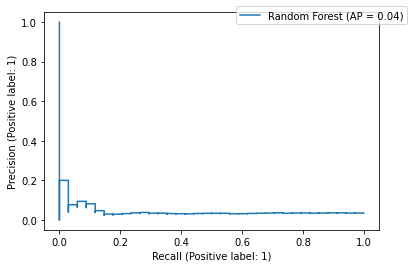

In [18]:
from sklearn.metrics import PrecisionRecallDisplay

model = pickle.load(open('models/use_class_weight/PCA_50_logit_42_256_0.pkl', 'rb'))

display = PrecisionRecallDisplay.from_estimator(
    model, X_val, y_val, name="Random Forest"
)

_ = display.ax_.legend(bbox_to_anchor=(1.1, 1.05))


## Image Resolution 512 x 512

In [ ]:
BATCH_SIZE = 488 # losing as less samples as possible
IMG_SIZE = (512, 512, 1)

BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/train' # directory of images preprocessed as numpy arrays
EXTRACTOR_PATH = '/home/irinb/models' # directory to save trained models

RANDOM_STATE = 42
HP = {'C': 1, 'penalty': 'l1', 'tol': 0.0001}


pca_logit_512 = rm.run_cv_training(
    
        model_name = 'logit',
        model_params = HP,
    
        cv_img = cv_img,
        label_img_dict = splitter.labels,
        patient_img_dict = splitter.trainset,
        
        from_numpy = True,
        basepath = BASEPATH,
        batch_size = BATCH_SIZE, 
        img_size = IMG_SIZE,
        n_classes = 2,
        shuffle = True,
        normalize = (0, 1),

        feature_extractor_name = 'PCA',
        CNN_preprocess=None,
        n_components = 50,
        model_path = EXTRACTOR_PATH,
        random_state = RANDOM_STATE,
 
        verbose = 1,
        return_none = False
        )

Fold:  0
---Loading feature extractor...
---Creating training and validation data generators...
---Initializing logistic regression model...
---Start training model
------Training batch  0
------Training batch  1
------Training batch  2
------Training batch  3
------Training batch  4
------Training batch  5
------Training batch  6
------Training batch  7
------Training batch  8
------Training batch  9
------Training batch  10
------Training batch  11
------Training batch  12
------Training batch  13
------Training batch  14
------Training batch  15
------Training batch  16
------Training batch  17
------Training batch  18
------Training batch  19
------Training batch  20
------Training batch  21
------Training batch  22
------Training batch  23
------Training batch  24
------Training batch  25
------Training batch  26
------Training batch  27
------Training batch  28
------Training batch  29
------Training batch  30
------Training batch  31
------Training batch  32
------Training batch

In [11]:
BATCH_SIZE = 488 # losing as less samples as possible
IMG_SIZE = (512, 512, 1)

BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/train' # directory of images preprocessed as numpy arrays
EXTRACTOR_PATH = '/home/irinb/models' # directory to save trained models

RANDOM_STATE = 42
HP = {'C': 1, 'penalty': 'l1', 'tol': 0.0001}


pca_logit_512 = rm.run_cv_training(
    
        model_name = 'logit',
        model_params = HP,
    
        cv_img = cv_img,
        label_img_dict = splitter.labels,
        patient_img_dict = splitter.trainset,
        
        from_numpy = True,
        basepath = BASEPATH,
        batch_size = BATCH_SIZE, 
        img_size = IMG_SIZE,
        n_classes = 2,
        shuffle = True,
        normalize = (0, 1),

        feature_extractor_name = 'PCA',
        CNN_preprocess=None,
        n_components = 50,
        model_path = EXTRACTOR_PATH,
        random_state = RANDOM_STATE,
 
        verbose = 1,
        return_none = False
        )

Fold:  0
logit model trained on this cross-validation fold already exist
--> /home/irinb/models/PCA_50_logit_42_512_0.pkl
Fold:  1
logit model trained on this cross-validation fold already exist
--> /home/irinb/models/PCA_50_logit_42_512_1.pkl
Fold:  2
---Loading feature extractor...
---Creating training and validation data generators...
---Initializing logistic regression model...
---Start training model
------Training batch  0


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  1


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  2


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  3


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  4


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  5


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  6


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  7


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  8


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  9


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  10


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  11


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  12


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  13


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  14


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  15


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  16


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  17


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  18


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  19


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  20


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  21


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  22


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  23


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  24


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  25


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  26


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  27


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  28


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  29


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  30


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  31


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  32


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  33


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  34


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  35


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  36


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  37


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  38


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  39


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  40


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  41


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  42


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  43


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  44


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  45


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  46


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  47


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  48


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  49


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  50


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  51


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  52


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  53


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  54


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  55


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  56
---Evaluating model


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Getting predictions for batch  0
------Calculating scores of batch  0
------Getting predictions for batch  1
------Calculating scores of batch  1
------Getting predictions for batch  2
------Calculating scores of batch  2
------Getting predictions for batch  3
------Calculating scores of batch  3
------Getting predictions for batch  4
------Calculating scores of batch  4
------Getting predictions for batch  5
------Calculating scores of batch  5
------Getting predictions for batch  6
------Calculating scores of batch  6
------Getting predictions for batch  7
------Calculating scores of batch  7
------Getting predictions for batch  8
------Calculating scores of batch  8
------Getting predictions for batch  9
------Calculating scores of batch  9
------Getting predictions for batch  10
------Calculating scores of batch  10
------Getting predictions for batch  11
------Calculating scores of batch  11
------Getting predictions for batch  12
------Calculating scores of batch  12
------

/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  1


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  2


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  3


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  4


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  5


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  6


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  7


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  8


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  9


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  10


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  11


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  12


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  13


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  14


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  15


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  16


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  17


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  18


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  19


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  20


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  21


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  22


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  23


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  24


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  25


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  26


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  27


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  28


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  29


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  30


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  31


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  32


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  33


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  34


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  35


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  36


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  37


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  38


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  39


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  40


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  41


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  42


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  43


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  44


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  45


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  46


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  47


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  48


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  49


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  50


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  51


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  52


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  53


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  54


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  55


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  56
---Evaluating model


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Getting predictions for batch  0
------Calculating scores of batch  0
------Getting predictions for batch  1
------Calculating scores of batch  1
------Getting predictions for batch  2
------Calculating scores of batch  2
------Getting predictions for batch  3
------Calculating scores of batch  3
------Getting predictions for batch  4
------Calculating scores of batch  4
------Getting predictions for batch  5
------Calculating scores of batch  5
------Getting predictions for batch  6
------Calculating scores of batch  6
------Getting predictions for batch  7
------Calculating scores of batch  7
------Getting predictions for batch  8
------Calculating scores of batch  8
------Getting predictions for batch  9
------Calculating scores of batch  9
------Getting predictions for batch  10
------Calculating scores of batch  10
------Getting predictions for batch  11
------Calculating scores of batch  11
------Getting predictions for batch  12
------Calculating scores of batch  12
------

/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  1


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  2


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  3


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  4


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  5


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  6


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  7


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  8


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  9


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  10


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  11


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  12


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  13


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  14


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  15


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  16


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  17


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  18


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  19


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  20


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  21


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  22


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  23


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  24


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  25


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  26


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  27


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  28


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  29


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  30


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  31


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  32


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  33


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  34


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  35


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  36


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  37


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  38


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  39


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  40


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  41


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  42


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  43


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  44


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  45


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  46


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  47


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  48


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  49


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  50


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  51


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  52


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  53


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  54


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  55


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  56
---Evaluating model


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Getting predictions for batch  0
------Calculating scores of batch  0
------Getting predictions for batch  1
------Calculating scores of batch  1
------Getting predictions for batch  2
------Calculating scores of batch  2
------Getting predictions for batch  3
------Calculating scores of batch  3
------Getting predictions for batch  4
------Calculating scores of batch  4
------Getting predictions for batch  5
------Calculating scores of batch  5
------Getting predictions for batch  6
------Calculating scores of batch  6
------Getting predictions for batch  7
------Calculating scores of batch  7
------Getting predictions for batch  8
------Calculating scores of batch  8
------Getting predictions for batch  9
------Calculating scores of batch  9
------Getting predictions for batch  10
------Calculating scores of batch  10
------Getting predictions for batch  11
------Calculating scores of batch  11
------Getting predictions for batch  12
------Calculating scores of batch  12
------

### Use class weights

In [19]:
pos = metadata[metadata.cancer==1].image_id.nunique()
neg = metadata[metadata.cancer==0].image_id.nunique()
total = metadata[metadata.patient_id.isin(splitter.trainset.keys())].image_id.nunique()

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.33
Weight for class 1: 15.11


In [20]:
BATCH_SIZE = 488 # losing as less samples as possible
IMG_SIZE = (512, 512, 1)

BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/train' # directory of images preprocessed as numpy arrays
EXTRACTOR_PATH = '/home/irinb/models' # directory to load pre-trained feature extractors
SAVEPATH = '/home/irinb/models/use_class_weight' # directory to save trained models

RANDOM_STATE = 42
HP = {'C': 1, 'penalty': 'l1', 'tol': 0.0001, 'class_weight': class_weight}

pca_logit_256 = rm.run_cv_training(
    
        model_name = 'logit',
        model_params = HP,
    
        cv_img = cv_img,
        label_img_dict = splitter.labels,
        patient_img_dict = splitter.trainset,
        
        from_numpy = True,
        img_basepath = BASEPATH,
        batch_size = BATCH_SIZE, 
        img_size = IMG_SIZE,
        n_classes = 2,
        shuffle = True,
        normalize = (0, 1),

        feature_extractor_name = 'PCA',
        CNN_preprocess=None,
        n_components = 50,
        extractor_path = EXTRACTOR_PATH,
        random_state = RANDOM_STATE,
 
        verbose = 1,
        return_model = False,
        savepath = SAVEPATH
        )

Fold:  0
---Loading feature extractor...
---Creating training and validation data generators...
---Initializing logistic regression model...
---Start training model
------Training batch  0


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  1


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  2


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  3


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  4


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  5


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  6


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  7


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  8


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  9


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  10


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  11


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  12


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  13


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  14


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  15


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  16


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  17


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  18


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  19


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  20


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  21


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  22


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  23


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  24


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  25


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  26


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  27


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  28


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  29


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  30


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  31


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  32


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  33


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  34


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  35


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  36


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  37


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  38


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  39


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  40


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  41


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  42


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  43


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  44


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  45


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  46


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  47


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  48


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  49


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  50


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  51


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  52


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  53


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  54


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  55


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  56


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


>>> Training time:  2326.8352386951447
---Evaluating model
------Getting predictions for batch  0
------Calculating scores of batch  0
------Getting predictions for batch  1
------Calculating scores of batch  1
------Getting predictions for batch  2
------Calculating scores of batch  2
------Getting predictions for batch  3
------Calculating scores of batch  3
------Getting predictions for batch  4
------Calculating scores of batch  4
------Getting predictions for batch  5
------Calculating scores of batch  5
------Getting predictions for batch  6
------Calculating scores of batch  6
------Getting predictions for batch  7
------Calculating scores of batch  7
------Getting predictions for batch  8
------Calculating scores of batch  8
------Getting predictions for batch  9
------Calculating scores of batch  9
------Getting predictions for batch  10
------Calculating scores of batch  10
------Getting predictions for batch  11
------Calculating scores of batch  11
------Getting predictions

/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  1


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  2


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  3


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  4


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  5


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  6


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  7


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  8


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  9


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  10


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  11


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  12


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  13


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  14


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  15


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  16


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  17


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  18


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  19


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  20


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  21


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  22


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  23


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  24


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  25


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  26


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  27


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  28


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  29


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  30


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  31


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  32


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  33


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  34


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  35


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  36


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  37


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  38


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  39


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  40


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  41


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  42


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  43


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  44


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  45


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  46


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  47


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  48


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  49


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  50


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


------Training batch  51


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  52


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  53


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  54


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  55


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  56


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


>>> Training time:  2311.6762475967407
---Evaluating model
------Getting predictions for batch  0
------Calculating scores of batch  0
------Getting predictions for batch  1
------Calculating scores of batch  1
------Getting predictions for batch  2
------Calculating scores of batch  2
------Getting predictions for batch  3
------Calculating scores of batch  3
------Getting predictions for batch  4
------Calculating scores of batch  4
------Getting predictions for batch  5
------Calculating scores of batch  5
------Getting predictions for batch  6
------Calculating scores of batch  6
------Getting predictions for batch  7
------Calculating scores of batch  7
------Getting predictions for batch  8
------Calculating scores of batch  8
------Getting predictions for batch  9
------Calculating scores of batch  9
------Getting predictions for batch  10
------Calculating scores of batch  10
------Getting predictions for batch  11
------Calculating scores of batch  11
------Getting predictions

/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  1


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  2


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


------Training batch  3


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  4


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  5


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  6


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  7


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  8


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  9


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  10


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  11


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  12


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  13


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  14


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  15


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  16


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  17


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  18


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  19


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  20


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  21


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  22


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  23


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  24


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  25


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  26


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  27


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  28


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  29


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  30


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  31


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  32


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  33


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  34


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  35


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  36


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  37


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  38


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  39


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  40


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  41


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


------Training batch  42


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  43


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  44


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  45


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  46


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  47


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  48


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  49


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  50


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  51


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  52


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  53


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  54


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  55


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  56


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


>>> Training time:  2308.456711769104
---Evaluating model
------Getting predictions for batch  0
------Calculating scores of batch  0
------Getting predictions for batch  1
------Calculating scores of batch  1
------Getting predictions for batch  2
------Calculating scores of batch  2
------Getting predictions for batch  3
------Calculating scores of batch  3
------Getting predictions for batch  4
------Calculating scores of batch  4
------Getting predictions for batch  5
------Calculating scores of batch  5
------Getting predictions for batch  6
------Calculating scores of batch  6
------Getting predictions for batch  7
------Calculating scores of batch  7
------Getting predictions for batch  8
------Calculating scores of batch  8
------Getting predictions for batch  9
------Calculating scores of batch  9
------Getting predictions for batch  10
------Calculating scores of batch  10
------Getting predictions for batch  11
------Calculating scores of batch  11
------Getting predictions 

/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  1


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  2


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  3


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  4


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  5


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  6


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  7


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  8


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  9


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  10


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  11


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  12


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  13


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  14


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  15


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  16


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  17


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  18


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  19


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  20


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  21


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  22


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  23


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


------Training batch  24


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  25


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  26


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  27


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  28


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  29


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  30


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  31


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  32


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  33


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  34


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  35


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  36


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  37


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  38


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  39


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  40


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  41


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  42


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  43


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  44


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  45


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  46


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  47


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  48


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  49


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  50


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  51


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  52


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  53


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  54


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  55


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  56


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


>>> Training time:  2406.0391387939453
---Evaluating model
------Getting predictions for batch  0
------Calculating scores of batch  0
------Getting predictions for batch  1
------Calculating scores of batch  1
------Getting predictions for batch  2
------Calculating scores of batch  2
------Getting predictions for batch  3
------Calculating scores of batch  3
------Getting predictions for batch  4
------Calculating scores of batch  4
------Getting predictions for batch  5
------Calculating scores of batch  5
------Getting predictions for batch  6
------Calculating scores of batch  6
------Getting predictions for batch  7
------Calculating scores of batch  7
------Getting predictions for batch  8
------Calculating scores of batch  8
------Getting predictions for batch  9
------Calculating scores of batch  9
------Getting predictions for batch  10
------Calculating scores of batch  10
------Getting predictions for batch  11
------Calculating scores of batch  11
------Getting predictions

/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  1


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  2


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  3


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  4


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  5


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  6


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


------Training batch  7


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  8


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  9


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  10


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  11


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  12


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  13


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  14


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  15


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  16


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  17


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  18


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  19


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  20


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  21


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  22


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  23


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  24


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  25


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  26


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  27


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  28


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  29


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  30


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  31


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  32


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  33


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  34


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  35


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  36


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  37


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  38


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  39


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  40


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  41


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  42


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  43


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  44


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  45


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  46


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  47


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  48


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  49


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  50


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  51


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  52


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  53


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  54


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  55


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  56


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


>>> Training time:  2748.1643788814545
---Evaluating model
------Getting predictions for batch  0
------Calculating scores of batch  0
------Getting predictions for batch  1
------Calculating scores of batch  1
------Getting predictions for batch  2
------Calculating scores of batch  2
------Getting predictions for batch  3
------Calculating scores of batch  3
------Getting predictions for batch  4
------Calculating scores of batch  4
------Getting predictions for batch  5
------Calculating scores of batch  5
------Getting predictions for batch  6
------Calculating scores of batch  6
------Getting predictions for batch  7
------Calculating scores of batch  7
------Getting predictions for batch  8
------Calculating scores of batch  8
------Getting predictions for batch  9
------Calculating scores of batch  9
------Getting predictions for batch  10
------Calculating scores of batch  10
------Getting predictions for batch  11
------Calculating scores of batch  11
------Getting predictions

## Image Resolution 1024 x 1024

In [12]:
BATCH_SIZE = 488 # losing as less samples as possible
IMG_SIZE = (1024, 1024, 1)

BASEPATH = '/scratch/siads699w23_class_root/siads699w23_class/irinb/train' # directory of images preprocessed as numpy arrays
EXTRACTOR_PATH = '/home/irinb/models' # directory to save trained models

RANDOM_STATE = 42
HP = {'C': 1, 'penalty': 'l1', 'tol': 0.0001}


pca_logit_512 = rm.run_cv_training(
    
        model_name = 'logit',
        model_params = HP,
    
        cv_img = cv_img,
        label_img_dict = splitter.labels,
        patient_img_dict = splitter.trainset,
        
        from_numpy = True,
        basepath = BASEPATH,
        batch_size = BATCH_SIZE, 
        img_size = IMG_SIZE,
        n_classes = 2,
        shuffle = True,
        normalize = (0, 1),

        feature_extractor_name = 'PCA',
        CNN_preprocess=None,
        n_components = 50,
        model_path = EXTRACTOR_PATH,
        random_state = RANDOM_STATE,
 
        verbose = 1,
        return_none = False
        )

Fold:  0
logit model trained on this cross-validation fold already exist
--> /home/irinb/models/PCA_50_logit_42_1024_0.pkl
Fold:  1
---Loading feature extractor...
---Creating training and validation data generators...
---Initializing logistic regression model...
---Start training model
------Training batch  0


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  1


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  2


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  3


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  4


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  5


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  6


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  7


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  8


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  9


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  10


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  11


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  12


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  13


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  14


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  15


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  16


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  17


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  18


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  19


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  20


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  21


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  22


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  23


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  24


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  25


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  26


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  27


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  28


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  29


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  30


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  31


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  32


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  33


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  34


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  35


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  36


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  37


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  38


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  39


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  40


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  41


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  42


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  43


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  44


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  45


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  46


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  47


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  48


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  49


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  50


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  51


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  52


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  53


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  54


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  55


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  56
---Evaluating model


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Getting predictions for batch  0
------Calculating scores of batch  0
------Getting predictions for batch  1
------Calculating scores of batch  1
------Getting predictions for batch  2
------Calculating scores of batch  2
------Getting predictions for batch  3
------Calculating scores of batch  3
------Getting predictions for batch  4
------Calculating scores of batch  4
------Getting predictions for batch  5
------Calculating scores of batch  5
------Getting predictions for batch  6
------Calculating scores of batch  6
------Getting predictions for batch  7
------Calculating scores of batch  7
------Getting predictions for batch  8
------Calculating scores of batch  8
------Getting predictions for batch  9
------Calculating scores of batch  9
------Getting predictions for batch  10
------Calculating scores of batch  10
------Getting predictions for batch  11
------Calculating scores of batch  11
------Getting predictions for batch  12
------Calculating scores of batch  12
------

/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  1


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  2


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  3


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  4


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  5


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  6


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  7


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  8


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  9


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  10


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  11


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  12


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  13


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  14


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  15


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  16


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  17


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  18


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  19


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  20


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  21


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  22


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  23


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  24


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  25


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  26


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  27


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  28


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  29


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  30


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  31


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  32


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  33


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  34


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  35


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  36


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  37


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  38


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  39


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  40


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  41


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  42


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  43


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  44


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  45


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  46


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  47


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  48


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  49


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  50


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  51


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  52


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  53


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  54


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  55


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  56
---Evaluating model


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Getting predictions for batch  0
------Calculating scores of batch  0
------Getting predictions for batch  1
------Calculating scores of batch  1
------Getting predictions for batch  2
------Calculating scores of batch  2
------Getting predictions for batch  3
------Calculating scores of batch  3
------Getting predictions for batch  4
------Calculating scores of batch  4
------Getting predictions for batch  5
------Calculating scores of batch  5
------Getting predictions for batch  6
------Calculating scores of batch  6
------Getting predictions for batch  7
------Calculating scores of batch  7
------Getting predictions for batch  8
------Calculating scores of batch  8
------Getting predictions for batch  9
------Calculating scores of batch  9
------Getting predictions for batch  10
------Calculating scores of batch  10
------Getting predictions for batch  11
------Calculating scores of batch  11
------Getting predictions for batch  12
------Calculating scores of batch  12
------

/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  1


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  2


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  3


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  4


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  5


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  6


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  7


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  8


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  9


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  10


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  11


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  12


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  13


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  14


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  15


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  16


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  17


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  18


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  19


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  20


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  21


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  22


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  23


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  24


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  25


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  26


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  27


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  28


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  29


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  30


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  31


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  32


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  33


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  34


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  35


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  36


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  37


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  38


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  39


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  40


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  41


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  42


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  43


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  44


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  45


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  46


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  47


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  48


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  49


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  50


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  51


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  52


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  53


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  54


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  55


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  56
---Evaluating model


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Getting predictions for batch  0
------Calculating scores of batch  0
------Getting predictions for batch  1
------Calculating scores of batch  1
------Getting predictions for batch  2
------Calculating scores of batch  2
------Getting predictions for batch  3
------Calculating scores of batch  3
------Getting predictions for batch  4
------Calculating scores of batch  4
------Getting predictions for batch  5
------Calculating scores of batch  5
------Getting predictions for batch  6
------Calculating scores of batch  6
------Getting predictions for batch  7
------Calculating scores of batch  7
------Getting predictions for batch  8
------Calculating scores of batch  8
------Getting predictions for batch  9
------Calculating scores of batch  9
------Getting predictions for batch  10
------Calculating scores of batch  10
------Getting predictions for batch  11
------Calculating scores of batch  11
------Getting predictions for batch  12
------Calculating scores of batch  12
------

/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  1


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  2


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  3


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  4


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  5


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  6


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  7


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  8


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  9


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  10


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  11


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  12


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  13


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  14


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  15


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  16


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  17


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  18


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  19


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  20


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  21


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  22


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  23


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  24


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  25


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  26


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  27


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  28


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  29


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  30


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  31


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  32


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  33


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  34


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  35


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  36


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  37


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  38


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  39


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  40


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  41


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  42


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  43


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  44


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  45


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  46


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  47


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  48


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  49


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  50


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  51


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  52


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  53


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  54


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  55


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Training batch  56
---Evaluating model


/home/irinb/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


------Getting predictions for batch  0
------Calculating scores of batch  0
------Getting predictions for batch  1
------Calculating scores of batch  1
------Getting predictions for batch  2
------Calculating scores of batch  2
------Getting predictions for batch  3
------Calculating scores of batch  3
------Getting predictions for batch  4
------Calculating scores of batch  4
------Getting predictions for batch  5
------Calculating scores of batch  5
------Getting predictions for batch  6
------Calculating scores of batch  6
------Getting predictions for batch  7
------Calculating scores of batch  7
------Getting predictions for batch  8
------Calculating scores of batch  8
------Getting predictions for batch  9
------Calculating scores of batch  9
------Getting predictions for batch  10
------Calculating scores of batch  10
------Getting predictions for batch  11
------Calculating scores of batch  11
------Getting predictions for batch  12
------Calculating scores of batch  12
------